# Assignment 1: Convolutional Neural Networks (CNNs)


## Import Packages


In [1]:
# Import torch packages
import torch
import torchvision as torchv

# Packages that are nice to have
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Get the Dataset


In [2]:
train_dataset = torchv.datasets.MNIST(
    root='./dataset/train',
    train=True,
    download=True,
    transform=torchv.transforms.ToTensor()
)
test_dataset = torchv.datasets.MNIST(
    root='./dataset/test',
    train=False,
    download=True,
    transform=torchv.transforms.ToTensor()
)

### What does the data look like?


In [3]:
print(train_dataset[0])
print(type(train_dataset[0]))

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

A single sample of the data is a tuple of length 2. This will be the input into our convolutional neural network!


In [4]:
# First element of tuple. This is an image!
print(train_dataset[0][0].shape)
print(type(train_dataset[0][0]))

torch.Size([1, 28, 28])
<class 'torch.Tensor'>


You may not be familiar with what a "tensor" is as of now. Just think of it as a datatype similar to an array!


Now we can look at a single sample of the second element. This will be our label (or "target" in PyTorch) to compare the output of our network to in order to determine the loss or error of our network so we can tell the network how to improve the network.

Keep in mind this is can also be called the ground-truth of the input sample.


In [5]:
# Second element is just a single integer!
print(train_dataset[0][1])
print(type(train_dataset[0][1]))

5
<class 'int'>


### What are these two elements of the single sample?


- The first element is an image of shape 1x28x28 (NumberOfChanngels \* Width \* Height) representing a single handwritten digit (i.e. a number between 0 and 9).
- The second element is a single digit integer representing the handwritten digit's perceived value contained within the image.


In the first element of the tuple, we see that the shape of the image is 1x28x28. Why do we have the single 1 in the front? This is the number of color channels the image has in it. In this case, we only have one color channel conveying that this image is simply a gray scale image!


**_Q1: How many color channels does a traditional colored image have?_**


Keep in mind that this is only ONE sample of the dataset!


In [6]:
print(f'There are {len(train_dataset)} samples in the training dataset!')
print(f'There are {len(test_dataset)} samples in the test dataset!')
print(
    f'Thus we have {len(train_dataset) + len(test_dataset)} ' +
    'samples in total!\n' +
    f'That is, we have a total of {len(train_dataset) + len(test_dataset)} ' +
    'tuples containing a single grayscale image and a single digit integer!'
)

There are 60000 samples in the training dataset!
There are 10000 samples in the test dataset!
Thus we have 70000 samples in total!
That is, we have a total of 70000 tuples containing a single grayscale image and a single digit integer!


### Combine and Split the Data


We currently have two separate parts of the dataset: the training data and the testing data. For this example we will combine these two into one large dataset of 70,000 samples and then split the dataset into three new datasets: train, validation, and testing.


In [7]:
# Get the data into numpy arrays
# (convert data to numpy format to manipulate later)
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()
print(
    f'Train Images: {train_images.shape}\n' +
    f'Train Labels: {train_labels.shape}\n' +
    f'Test Images: {test_images.shape}\n' +
    f'Test Labels: {test_labels.shape}\n'
)

Train Images: (60000, 28, 28)
Train Labels: (60000,)
Test Images: (10000, 28, 28)
Test Labels: (10000,)



In [8]:
# Combine the train and test dataset into one big dataset
all_images = np.concat([train_images, test_images])
all_labels = np.concat([train_labels, test_labels])
print(
    f'All Images: {all_images.shape}\n' +
    f'All Labels: {all_labels.shape}\n'
)

All Images: (70000, 28, 28)
All Labels: (70000,)



Notice! That the color channel dimension of 1 was removed! This is fine for now. We will add it back later!


So now that we have one large dataset, we split the data into the proportions we wish to use for our three separate datasets for training, validation, and testing.


In [9]:
# Split the large numpy array into smaller train, validation, and test splits
choices = np.arange(len(all_labels))
# Specify the percentages of samples each set should contain
# NOTE: The last percentage is not important here since we will just
#       use the remaining images after we take out the training and validation
#       sets.
train_perc, val_perc, test_perc = (0.7, 0.2, 0.1)
# Get the number of total samples
num_samples = len(all_labels)
# Calculate the number train samples we want
num_train = int(np.floor(num_samples * train_perc))
# Calculate the number of validation samples we want
num_val = int(np.floor(num_samples * val_perc))
# Calculate the number of test samples we want
num_test = num_samples - num_train - num_val
# Show the number of samples in each
num_train, num_val, num_test

(49000, 14000, 7000)

In [10]:
# Randomly select indices throughout the whole dataset
train_idx = np.random.choice(choices, num_train, replace=False)
# Get the set difference between the whole dataset and the chosen training
# indices
choices = np.setdiff1d(choices, train_idx)
# Now get randomly choose the validation indices
val_idx = np.random.choice(choices, num_val, replace=False)
# Similarly, get the set difference but this time the resulting difference
# is, in fact, the test set.
test_idx = np.setdiff1d(choices, val_idx)
# Show index sets
train_idx, val_idx, test_idx

(array([69215, 33580, 67821, ..., 51745, 62972, 11214], shape=(49000,)),
 array([58661, 10693, 33424, ..., 46202, 19572, 44042], shape=(14000,)),
 array([   31,    32,    40, ..., 69962, 69972, 69995], shape=(7000,)))

In [11]:
# Ensure disjoint sets i.e. none of the elements overlap between the new
# three datasets of train, validation, and test.
np.intersect1d(np.intersect1d(train_idx, val_idx), test_idx)

array([], dtype=int64)

In [12]:
# Now we actually get all of the images and labels corresponding to their
# sets using the indices we randomly chose
train_images, train_labels = all_images[train_idx], all_labels[train_idx]
val_images, val_labels = all_images[val_idx], all_labels[val_idx]
test_images, test_labels = all_images[test_idx], all_labels[test_idx]

### Helper Functions and Custom Dataset Definition


In [13]:
def transform(image):
    """Perform a transform on an input image. This can include normalization,
    padding, and other transformations/augmentations.

    :param image: The input image.
    :type image: Typically a numpy array.
    :return: A new transformed image.
    :rtype: _type_
    """
    x = np.pad(image, pad_width=2)
    x = np.reshape(x, (1, 32, 32))
    x = torch.Tensor(x / 255.0)
    return x


def target_transform(label):
    """Perform transformations on the label (i.e. "target").

    :param label: An input integer in this case
    :type label: A number that we should typecast to integer.
    :return: A transformed label.
    :rtype: int
    """
    x = int(label)
    return x


class MNIST_Dataset(torch.utils.data.Dataset):
    """Create a custom PyTorch dataset with all of the necessary functions to
    properly work with other PyTorch operations/functions.
    """

    def __init__(
        self,
        images,
        labels,
        transform=transform,
        target_transform=target_transform
    ):
        """The constructor for the class. Initialize variables.

        :param images: A group of images.
        :param labels: A group of labels.
        :param transform: Transform function to apply to images, 
            defaults to transform
        :type transform: function, optional
        :param target_transform: Transform function to apply to the labels,
            defaults to target_transform
        :type target_transform: function, optional
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Get the length of the dataset.

        :return: The length of the labels i.e. the number of elements in the
            dataset.
        :rtype: int
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """Get a single element of the dataset via its index and perform the
        necessary transforms upon it.

        :param idx: The index of the element to retrieve.
        :type idx: int
        :return: A tuple grouping the image and the label.
        :rtype: tuple
        """
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
# Use our custom dataset definition class to wrap our dataset for use with other
# PyTorch tools i.e. the PyTorch dataloader.
train_dataset = MNIST_Dataset(
    train_images, train_labels, transform=transform, target_transform=target_transform)
val_dataset = MNIST_Dataset(
    val_images, val_labels, transform=transform, target_transform=target_transform)
test_dataset = MNIST_Dataset(
    test_images, test_labels, transform=transform, target_transform=target_transform)

## Visualize the Data


Now let's pause and analyze our data.


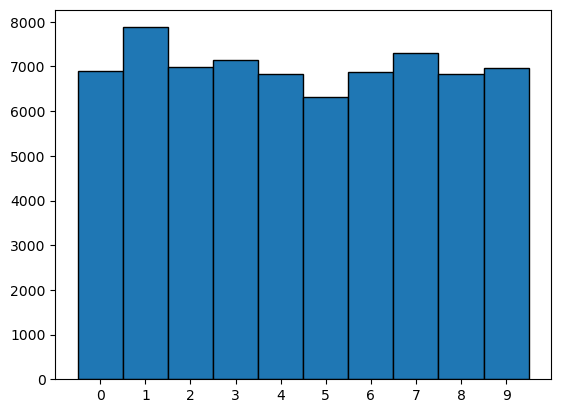

In [15]:
# Histogram showing the frequency of each class in the dataset
plt.hist(all_labels, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.show()

We can see that we have mixed distribution of frequencies among the 10 classes of handwritten digits with handwritten 1s having the most samples and the 5s having the least samples.


**_Q2: What happens if our distribution is very unbalanced meaning we have widely different quantities of classes?_**


Now, if we look at the distribution over the train, validation, and test sets, we can see that the distributions are roughly proportional to what we saw previously when the all of the data was contained within a single large dataset.


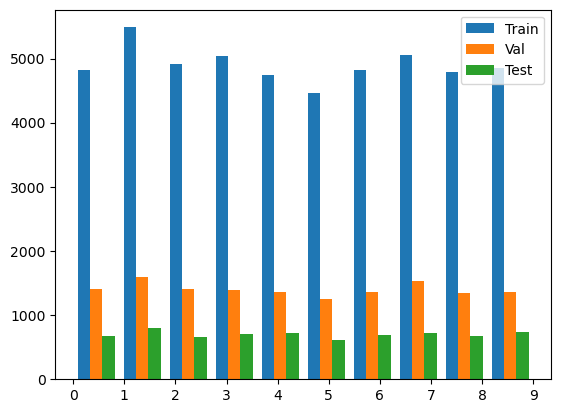

In [16]:
# Frequencies of each class in the 3 separate datasets
labels = np.unique(train_labels)
plt.hist([train_labels, val_labels, test_labels])
plt.xticks(labels)
plt.legend(['Train', 'Val', 'Test'])

Now we can get an idea of what our data actually looks like. Here, we have printed a single sample of each class and displayed their corresponding label above them.


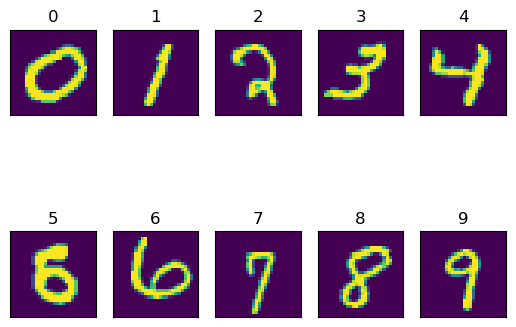

In [17]:
# Displaying one sample of each class
visualization_samples = []
plt.subplot(2, 5, 1)
for i in range(10):
    indices = np.where(train_labels == i)[0]
    rand_idx = indices[np.random.randint(0, len(indices) - 1)]
    plt.subplot(2, 5, i+1)
    plt.imshow(np.squeeze(train_images[rand_idx]))
    plt.yticks([])
    plt.xticks([])
    plt.title(i)

## Create the Dataloaders


In many cases our entire dataset may not fit entirely in memory (i.e. RAM). In our case of MNIST, this typically isn't a problem, but for larger datasets and higher dimensional data (i.e. ImageNet datasets), it is common that we need a way to load our data such that it fits in memory.

We can customize the code in the MNIST_Dataset class to allow use to only read data from the disk (Hard Drive or Solid State Drive) when needed. This can be seen in the PyTorch examples of the Dataset and Dataloader documentation/tutorials: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In this case, we are not concerned with memory limitations, unless the system you are running this tutorial on is extremely limited in memory. Thus we have the entire dataset loaded into memory and can freely manipulate it.

In many cases, it is much more efficient to use data batching to batch our data when training to speed up training. Instead of inputting a single image, computing the loss, and then backpropogating the error and adjusting the weights, we can perform the forward pass (i.e. input) several images at once and then compute the loss on those samples together and then backpropogate their error.


**_Q3: What do we mean by "train faster" or "more efficiently" here? That is what is faster or more efficient?_**


### Parameters


In [18]:
# In this tutorial, we will use a batch size of 32 whilst training
BATCH_SIZE = 32

In [19]:
# Here we initialize the Dataloaders, set the batch size to load BATCH_SIZE
# samples at a time and also perform a random shuffle of the samples within
# each set of data.
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

**_Q4: Why do we shuffle the data even within the randomly chosen samples in each dataset?_**


## Create the CNN Model


Here we instantiate two CNN models both being based off of Yann LeCun et. al.'s LeNet-5 CNN proposed in their publication "Gradient-Based Learning Applied to Document Recognition" circa 1998.


### Parameters


In [20]:
# We have 10 different classes of data we want to differentiate between
# (i.e. the handwritten single digit number zero thru nine)
NUM_CLASSES = 10

### Classic LeNet-5


Here we define a close-to-classical version of LeNet-5 which is very similar to what Yann LeCun et. al. proposed in 1998.


In [21]:
class OGLeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers
        self.conv1 = torch.nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.avgpool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.avgpool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, out_features=NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.functional.F.tanh(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = torch.functional.F.tanh(x)
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = torch.functional.F.tanh(x)
        x = self.linear2(x)
        x = torch.functional.F.tanh(x)
        x = self.linear3(x)
        return x

### Inspect the Original LeNet-5 Model


In [22]:
original_lenet5 = OGLeNet5()
summary(original_lenet5, (1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Flatten: 1-5                           [-1, 400]                 --
├─Linear: 1-6                            [-1, 120]                 48,120
├─Linear: 1-7                            [-1, 84]                  10,164
├─Linear: 1-8                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Flatten: 1-5                           [-1, 400]                 --
├─Linear: 1-6                            [-1, 120]                 48,120
├─Linear: 1-7                            [-1, 84]                  10,164
├─Linear: 1-8                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29

### Define a More Modern LeNet-5


Here we provide a more modernize version of LeNet-5 with layers and operations that were not yet available or discovered at the time of LeNet-5's creation.


In [23]:
class ModernLeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers
        self.conv1 = torch.nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.batchnorm1 = torch.nn.BatchNorm2d(6)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.batchnorm2 = torch.nn.BatchNorm2d(16)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, out_features=NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = torch.functional.F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = torch.functional.F.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = torch.functional.F.relu(x)
        x = self.linear2(x)
        x = torch.functional.F.relu(x)
        x = self.linear3(x)
        return x

### Inspect the Modernized LeNet-5 Model


In [24]:
modern_lenet5 = ModernLeNet5()
summary(modern_lenet5, (1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─BatchNorm2d: 1-2                       [-1, 6, 28, 28]           12
├─MaxPool2d: 1-3                         [-1, 6, 14, 14]           --
├─Conv2d: 1-4                            [-1, 16, 10, 10]          2,416
├─BatchNorm2d: 1-5                       [-1, 16, 10, 10]          32
├─MaxPool2d: 1-6                         [-1, 16, 5, 5]            --
├─Flatten: 1-7                           [-1, 400]                 --
├─Linear: 1-8                            [-1, 120]                 48,120
├─Linear: 1-9                            [-1, 84]                  10,164
├─Linear: 1-10                           [-1, 10]                  850
Total params: 61,750
Trainable params: 61,750
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.24
Estimated Total Size (MB): 0.34


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─BatchNorm2d: 1-2                       [-1, 6, 28, 28]           12
├─MaxPool2d: 1-3                         [-1, 6, 14, 14]           --
├─Conv2d: 1-4                            [-1, 16, 10, 10]          2,416
├─BatchNorm2d: 1-5                       [-1, 16, 10, 10]          32
├─MaxPool2d: 1-6                         [-1, 16, 5, 5]            --
├─Flatten: 1-7                           [-1, 400]                 --
├─Linear: 1-8                            [-1, 120]                 48,120
├─Linear: 1-9                            [-1, 84]                  10,164
├─Linear: 1-10                           [-1, 10]                  850
Total params: 61,750
Trainable params: 61,750
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.24
Estimated Total Size (MB): 0.34

**_Q5: What are the differences between these two models in their architectures?_**


## Setup the Loss Functions and Optimizer


### Paremeters


In [25]:
# This is our learning rate for both models
LEARNING_RATE = 0.001

In [26]:
# Setup our loss function
loss = torch.nn.CrossEntropyLoss()

# Setup an optimizer for each of the two models
optim_original_lenet5 = torch.optim.Adam(
    original_lenet5.parameters(), lr=LEARNING_RATE)
optim_modern_lenet5 = torch.optim.Adam(
    modern_lenet5.parameters(), lr=LEARNING_RATE)

## Train the CNN Model


### Parameters


In [27]:
# Define the number of training epochs to loop of the entire dataset
NUM_EPOCHS = 10
# Determine if we should use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
def compute_accuracy(outputs, labels):
    # Get the class index with the highest activation
    # In this case it corresponds to the digit with the highest likelihood of
    # being the number depicted in the input
    predictions = torch.argmax(outputs, 1)
    # Number of total predictions (i.e. the batch size)
    num_predictions = len(predictions)
    # Count the number of elements in the difference that are NOT zero
    # This indicates a mis-classification by the model
    num_incorrect = torch.count_nonzero(predictions - labels)
    # Compute the accuracy i.e. total - incorrect divided by total
    accuracy = (num_predictions - num_incorrect)/num_predictions
    return accuracy.item()

In [29]:
def train(
    train_dataloader,
    model,
    loss_function,
    optimizer,
    epoch,
    num_epochs,
    total_steps,
    device
):
    running_acc = 0.0
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        # Move the data to the desired training device
        images = images.to(device)
        labels = labels.to(device)

        # Perform the forward pass
        outputs = model(images)

        # Compute the loss
        loss = loss_function(outputs, labels)

        # Compute accuracy metric
        acc = compute_accuracy(outputs, labels)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform the backwards pass (i.e. backpropogate the error)
        loss.backward()

        # Optimize
        optimizer.step()

        # Add the running accuracy and loss
        running_loss += loss.item()
        running_acc += acc

        # Progressively print loss
        if (i+1) % 256 == 0:
            print(
                f'TRAINING --> Epoch: {epoch+1}/{num_epochs}, ' +
                f'Step: {i+1}/{total_steps}, ' +
                f'Loss: {running_loss / (i+1)}, '
                f'Accuracy: {running_acc / (i+1)}'
            )
    # Compute the average loss and accuracy for this epoch
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [30]:
def validation(
    val_dataloader,
    model,
    loss_function,
    epoch,
    num_epochs,
    total_steps,
    device
):
    running_loss = 0.0
    running_acc = 0.0
    # Now we run over the validation dataset without training
    if val_dataloader:
        # Disable the gradient calculations and updates
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_dataloader):
                # Transfer input data to device
                images = images.to(device)
                labels = labels.to(device)

                # Perform inference
                outputs = model(images)

                # Compute validation loss
                loss = loss_function(outputs, labels)

                # Compute validation accuracy
                acc = compute_accuracy(outputs, labels)

                # Add the running accuracy and loss
                running_loss += loss.item()
                running_acc += acc

                # Progressively print loss
                if (i+1) % 256 == 0:
                    print(
                        f'VALIDATION --> Epoch: {epoch+1}/{num_epochs}, ' +
                        f'Step: {i+1}/{total_steps}, ' +
                        f'Val Loss: {running_loss / (i+1)}, ' +
                        f'Val Acc: {running_acc / (i+1)}'
                    )
    # Compute the average loss and accuracy for this epoch
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [31]:
def save_best_model(
    model: torch.nn.Module,
    model_save_path: Path,
    val_loss: float,
    val_losses: list,
    epoch: int,
    keep_models: bool = False
):
    # Should we keep all models or just one
    if keep_models:
        model_save_path = model_save_path / f'model_{epoch+1}_{val_loss}.pt'
    else:
        model_save_path = model_save_path / f'model_state_dict.pt'
    # Save the first model
    if len(val_losses) == 0:
        torch.save(
            model.state_dict(),
            model_save_path
        )
        print(
            'SAVING --> First epoch: \n' +
            f'Val Loss: {val_loss}\n' +
            f'Saving new model to:\n{model_save_path}'
        )
    elif val_loss < min(val_losses):
        # If our new validation loss is less than the previous best save the
        # model
        print(
            'SAVING --> Found model with better validation loss: \n' +
            f'New Best Val Loss: {val_loss}\n' +
            f'Old Best Val Loss: {min(val_losses)}\n'
            f'Saving new model to:\n{model_save_path}'
        )
        torch.save(
            model.state_dict(),
            model_save_path
        )

In [32]:
def train_model(
    train_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_function: torch.nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam,
    num_epochs: int,
    device: str,
    model_save_path: Path = Path('./models'),
    val_dataloader: torch.utils.data.DataLoader = None,
):
    """Training loop which iterates over every image in the training dataset,
    performs the forward pass, computes the loss, and then performs the
    backwards pass.

    See: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    """
    print(f'Models will be saved to: {model_save_path}')
    # Lists for recording stats over epochs
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Create the save path for the model
    if not model_save_path.exists():
        model_save_path.mkdir(exist_ok=True, parents=True)

    # Total number batches in training set
    train_total_steps = len(train_dataloader)
    val_total_steps = len(val_dataloader)

    # Perform training loop
    for epoch in range(num_epochs):
        # Enable model training
        model.train(True)

        # Enter the training function loop
        train_loss, train_acc = train(
            train_dataloader,
            model,
            loss_function,
            optimizer,
            epoch,
            num_epochs,
            train_total_steps,
            device
        )
        print(
            f'TRAINING --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {train_loss}, Avg Accuracy: {train_acc}'
        )

        # Enter the validation loop
        val_loss, val_acc = validation(
            val_dataloader,
            model,
            loss_function,
            epoch,
            num_epochs,
            val_total_steps,
            device
        )
        print(
            f'VALIDATION --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {val_loss}, Avg Accuracy: {val_acc}'
        )

        # Determine if we should save the model
        save_best_model(model, model_save_path, val_loss, val_losses, epoch)

        # Record the stats
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return (train_losses, train_accs), (val_losses, val_accs)

**_Q6: What is the purpose of the loss function?_**

**_Q7: What is validation doing?_**

**_Q8: Why do we perform validation and not just use the training metrics?_**


In [33]:
def plot_epoch_metrics(x, y, data_names, title_prefix, yaxis_label):
    for i in y:
        plt.plot(x, i)
    plt.title(title_prefix + ' ' + ' vs. '.join(data_names) + ' ' + yaxis_label)
    plt.ylabel(yaxis_label)
    plt.legend(data_names)

In [34]:
# Train the original version of LeNet5
original_lenet5.to(DEVICE)
(train_losses, train_accs), (val_losses, val_accs) = train_model(
    train_dataloader,
    original_lenet5,
    loss,
    optim_original_lenet5,
    NUM_EPOCHS,
    DEVICE,
    model_save_path=Path('./models/original_lenet5'),
    val_dataloader=val_dataloader
)
# Get the best validation loss and accuracy
print(
    f'Best Validation Loss: {min(val_losses)} ' +
    f'after epoch {np.argmin(val_losses) + 1}'
)
print(
    f'Best Validation Acc: {max(val_accs)} ' +
    f'after epoch {np.argmax(val_accs) + 1}'
)

Models will be saved to: models/original_lenet5
TRAINING --> Epoch: 1/10, Step: 256/1532, Loss: 0.6656761073681992, Accuracy: 0.8126220703125
TRAINING --> Epoch: 1/10, Step: 512/1532, Loss: 0.46792991756956326, Accuracy: 0.86639404296875
TRAINING --> Epoch: 1/10, Step: 768/1532, Loss: 0.37644154609491426, Accuracy: 0.891357421875
TRAINING --> Epoch: 1/10, Step: 1024/1532, Loss: 0.32504185040488665, Accuracy: 0.90557861328125
TRAINING --> Epoch: 1/10, Step: 1280/1532, Loss: 0.2873657866904978, Accuracy: 0.916259765625
TRAINING --> Epoch 1/10 DONE, Avg Loss: 0.259667991404604, Avg Accuracy: 0.9243023825065274
VALIDATION --> Epoch: 1/10, Step: 256/438, Val Loss: 0.12401483314533834, Val Acc: 0.9627685546875
VALIDATION --> Epoch 1/10 DONE, Avg Loss: 0.12260088077044651, Avg Accuracy: 0.963755707762557
SAVING --> First epoch: 
Val Loss: 0.12260088077044651
Saving new model to:
models/original_lenet5/model_state_dict.pt
TRAINING --> Epoch: 2/10, Step: 256/1532, Loss: 0.09526334590191254, Acc

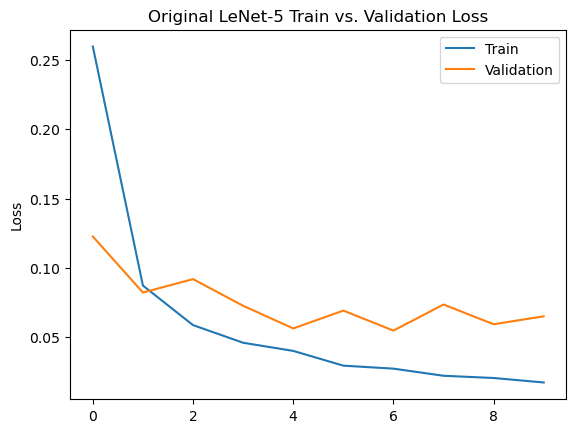

In [35]:
plot_epoch_metrics(
    np.arange(10),
    [train_losses, val_losses],
    ['Train', 'Validation'],
    'Original LeNet-5',
    'Loss'
)

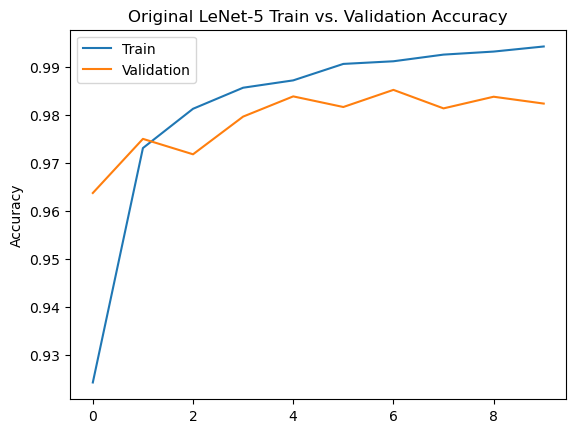

In [36]:
plot_epoch_metrics(
    np.arange(10),
    [train_accs, val_accs],
    ['Train', 'Validation'],
    'Original LeNet-5',
    'Accuracy'
)

In [37]:
# Train the modern version of LeNet5
modern_lenet5.to(DEVICE)
(train_losses, train_accs), (val_losses, val_accs) = train_model(
    train_dataloader,
    modern_lenet5,
    loss,
    optim_modern_lenet5,
    NUM_EPOCHS,
    DEVICE,
    model_save_path=Path('./models/modern_lenet5'),
    val_dataloader=val_dataloader
)
# Get the best validation loss and accuracy
print(
    f'Best Validation Loss: {min(val_losses)} ' +
    f'after epoch {np.argmin(val_losses) + 1}'
)
print(
    f'Best Validation Acc: {max(val_accs)} ' +
    f'after epoch {np.argmax(val_accs) + 1}'
)

Models will be saved to: models/modern_lenet5
TRAINING --> Epoch: 1/10, Step: 256/1532, Loss: 0.45823940394620877, Accuracy: 0.86474609375
TRAINING --> Epoch: 1/10, Step: 512/1532, Loss: 0.29971313973874203, Accuracy: 0.91131591796875
TRAINING --> Epoch: 1/10, Step: 768/1532, Loss: 0.23390283744265616, Accuracy: 0.9296875
TRAINING --> Epoch: 1/10, Step: 1024/1532, Loss: 0.19896633754478898, Accuracy: 0.940155029296875
TRAINING --> Epoch: 1/10, Step: 1280/1532, Loss: 0.1764454239490078, Accuracy: 0.9466064453125
TRAINING --> Epoch 1/10 DONE, Avg Loss: 0.15973082973816927, Avg Accuracy: 0.9515543407310705
VALIDATION --> Epoch: 1/10, Step: 256/438, Val Loss: 0.0766614074645986, Val Acc: 0.9771728515625
VALIDATION --> Epoch 1/10 DONE, Avg Loss: 0.07526298441985818, Avg Accuracy: 0.9771689497716894
SAVING --> First epoch: 
Val Loss: 0.07526298441985818
Saving new model to:
models/modern_lenet5/model_state_dict.pt
TRAINING --> Epoch: 2/10, Step: 256/1532, Loss: 0.06561496093809183, Accuracy:

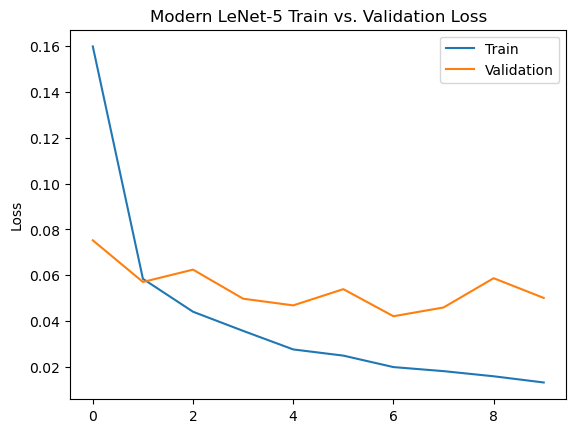

In [38]:
plot_epoch_metrics(
    np.arange(10),
    [train_losses, val_losses],
    ['Train', 'Validation'],
    'Modern LeNet-5',
    'Loss'
)

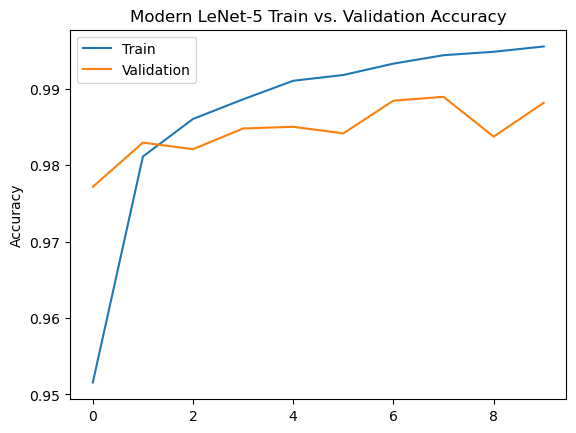

In [39]:
plot_epoch_metrics(
    np.arange(10),
    [train_accs, val_accs],
    ['Train', 'Validation'],
    'Modern LeNet-5',
    'Accuracy'
)

**_Q8: In terms of validation accuracy, which model is the best?_**


**_Q9: Is the model under-fitting or over-fitting?_**


## Test the Model


In [40]:
def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
    cm_display.plot()
    plt.show()

In [41]:
def test_model(
    test_dataloader,
    model_class: torch.nn.Module,
    model_weights_path,
    device,
    loss_function
):
    model: torch.nn.Module = model_class()
    model.load_state_dict(torch.load(model_weights_path, weights_only=True))
    model.eval()

    model.to(device)
    total_steps = len(test_dataloader)
    running_loss = 0.0
    running_acc = 0.0
    all_predictions = []
    all_labels = []
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = loss_function(outputs, labels)
        accuracy = compute_accuracy(outputs, labels)

        running_loss += loss.item()
        running_acc += accuracy

        all_predictions = all_predictions + torch.argmax(outputs, 1).tolist()
        all_labels = all_labels + labels.tolist()
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps
    return running_loss, running_acc, all_predictions, all_labels

In [42]:
og_test_loss, og_test_acc, predictions, labels = test_model(
    test_dataloader,
    OGLeNet5,
    './models/original_lenet5/model_state_dict.pt',
    DEVICE,
    loss
)
print('Original LeNet-5 Inference Performance')
print(f'Test dataset contains {len(test_dataset)} samples.')
print(f'Testing Avg Loss: {og_test_loss}')
print(f'Testing Avg Acc: {og_test_acc}')

Original LeNet-5 Inference Performance
Test dataset contains 7000 samples.
Testing Avg Loss: 0.051785841551447206
Testing Avg Acc: 0.9843036529680366


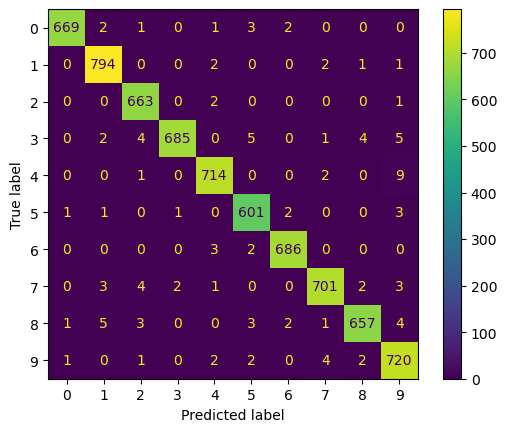

In [43]:
plot_confusion_matrix(labels, predictions)

In [44]:
modern_test_loss, modern_test_acc, predictions, labels = test_model(
    test_dataloader,
    ModernLeNet5,
    './models/modern_lenet5/model_state_dict.pt',
    DEVICE,
    loss
)
print('Modern LeNet-5 Inference Performance')
print(f'Test dataset contains {len(test_dataset)} samples.')
print(f'Testing Avg Loss: {modern_test_loss}')
print(f'Testing Avg Acc: {modern_test_acc}')

Modern LeNet-5 Inference Performance
Test dataset contains 7000 samples.
Testing Avg Loss: 0.042871389558814414
Testing Avg Acc: 0.9901065450825103


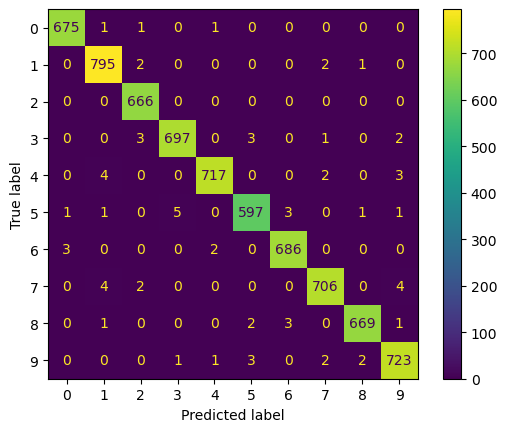

In [45]:
plot_confusion_matrix(labels, predictions)

**_Q10: How does the test loss and accuracy compare to the best training and validation metrics?_**
